# Classical ML for Image Classification

### Importing the feature extracted raw data 

In [1]:
import pandas as pd

df = pd.read_csv("data\leaf_features.xlsx")

In [2]:
df.head()

,class,image_name,brightness,texture_0,texture_1,texture_2,texture_3,texture_4,texture_5,texture_6,...,hist_54,hist_55,hist_56,hist_57,hist_58,hist_59,hist_60,hist_61,hist_62,hist_63
0,BACT,BACT_0,105.681213,0.000213,179.414974,0.961457,2327.073882,0.162140,211.321734,9128.880553,...,0.002378,0.002118,0.001198,0.001111,0.000486,0.000278,0.000069,0.000017,0.000000,0.0
1,BACT,BACT_1,121.675126,0.000291,248.781522,0.852087,841.118487,0.123878,243.199118,3115.692426,...,0.000260,0.000208,0.000295,0.000313,0.000226,0.000035,0.000052,0.000069,0.000035,0.0
2,BACT,BACT_10,121.750298,0.000424,599.545049,0.892747,2795.011877,0.130888,243.401063,10580.502458,...,0.008003,0.006944,0.006858,0.007014,0.007865,0.007292,0.005226,0.001128,0.000035,0.0
3,BACT,BACT_11,118.741499,0.000262,250.616348,0.954806,2772.998259,0.160693,237.585471,10841.376687,...,0.003212,0.002795,0.001458,0.001233,0.000382,0.000000,0.000000,0.000000,0.000000,0.0
4,BACT,BACT_12,109.830653,0.000250,219.855194,0.958645,2659.035096,0.149557,219.799164,10416.285189,...,0.000451,0.000122,0.000017,0.000017,0.000017,0.000000,0.000000,0.000000,0.000000,0.0


In [3]:
df.columns

Index(['class', 'image_name', 'brightness', 'texture_0', 'texture_1',
       'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6',
       'texture_7', 'texture_8', 'texture_9', 'texture_10', 'texture_11',
       'texture_12', 'hist_0', 'hist_1', 'hist_2', 'hist_3', 'hist_4',
       'hist_5', 'hist_6', 'hist_7', 'hist_8', 'hist_9', 'hist_10', 'hist_11',
       'hist_12', 'hist_13', 'hist_14', 'hist_15', 'hist_16', 'hist_17',
       'hist_18', 'hist_19', 'hist_20', 'hist_21', 'hist_22', 'hist_23',
       'hist_24', 'hist_25', 'hist_26', 'hist_27', 'hist_28', 'hist_29',
       'hist_30', 'hist_31', 'hist_32', 'hist_33', 'hist_34', 'hist_35',
       'hist_36', 'hist_37', 'hist_38', 'hist_39', 'hist_40', 'hist_41',
       'hist_42', 'hist_43', 'hist_44', 'hist_45', 'hist_46', 'hist_47',
       'hist_48', 'hist_49', 'hist_50', 'hist_51', 'hist_52', 'hist_53',
       'hist_54', 'hist_55', 'hist_56', 'hist_57', 'hist_58', 'hist_59',
       'hist_60', 'hist_61', 'hist_62', 'hist_63']

## Feature Scaling / Normalization
        ----- To ensure that models are not biased by features with large scales:

In [4]:
from sklearn.preprocessing import StandardScaler

# Drop target columns and scale only features
X = df.drop(["class", "image_name"], axis=1)
y = df["class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import warnings

warnings.filterwarnings("ignore")



# LOAD AND PREPARE DATA
# ------------------------


In [6]:
df = pd.read_csv("data\leaf_features.xlsx")

X = df.drop(columns=["class", "image_name"])
y = df["class"]

# Label encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

### Split the data into 80% train and 20% test splits:

In [7]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [8]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

### Define Models and hyperparameter space for Grid-Search CV 
    


# MODEL CONFIGURATIONS


In [9]:
models = {
    "SVC": (
        SVC(probability=True),
        {
            "C": [0.00015, 0.00125, 0.1, 1, 5, 10],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "decision_function_shape": ["ovo", "ovr"],
        },
    ),
    "RandomForest": (
        RandomForestClassifier(),
        {
            "n_estimators": [2, 5, 10, 20, 50, 100, 200],
            "criterion": ["gini", "entropy", "log_loss"],
            "max_depth": [2, 3, 4, 5, 7, 10, None],
        },
    ),
    "DecisionTree": (
        DecisionTreeClassifier(),
        {
            "max_depth": [1, 2, 3, 4, 5, 8, 10, None],
            "criterion": ["gini", "entropy", "log_loss"],
            "max_leaf_nodes": [1, 2, 3, 5, 8, 10],
        },
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
        {
            "n_estimators": [100, 200],
            "max_depth": [3, 6],
            "learning_rate": [0.00125, 0.00257, 0.014, 0.1],
        },
    ),
}



# Mlflow Experimentation /

🔍 Training SVC...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


2025/07/23 02:43:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 02:43:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ SVC complete. Best Params: {'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
🔍 Training RandomForest...
Fitting 5 folds for each of 147 candidates, totalling 735 fits


2025/07/23 02:44:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 02:44:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ RandomForest complete. Best Params: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
🔍 Training DecisionTree...
Fitting 5 folds for each of 144 candidates, totalling 720 fits


2025/07/23 02:44:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 02:44:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ DecisionTree complete. Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 10}
🔍 Training XGBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


2025/07/23 02:45:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 02:45:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ XGBoost complete. Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


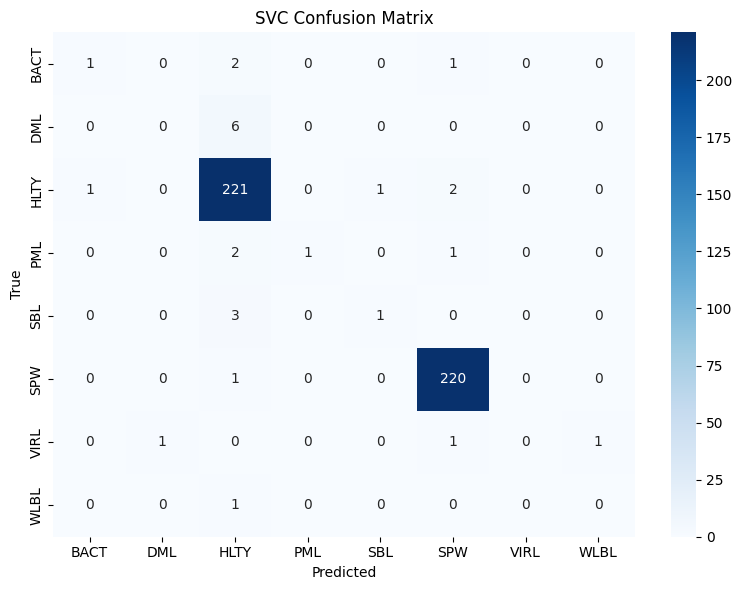

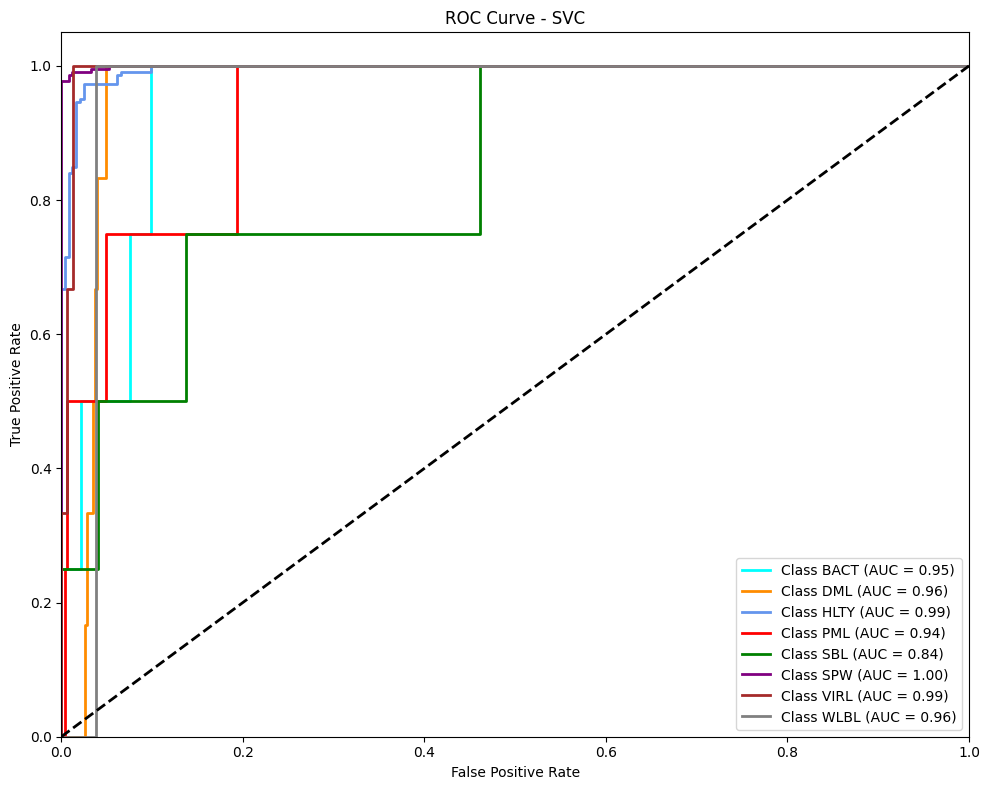

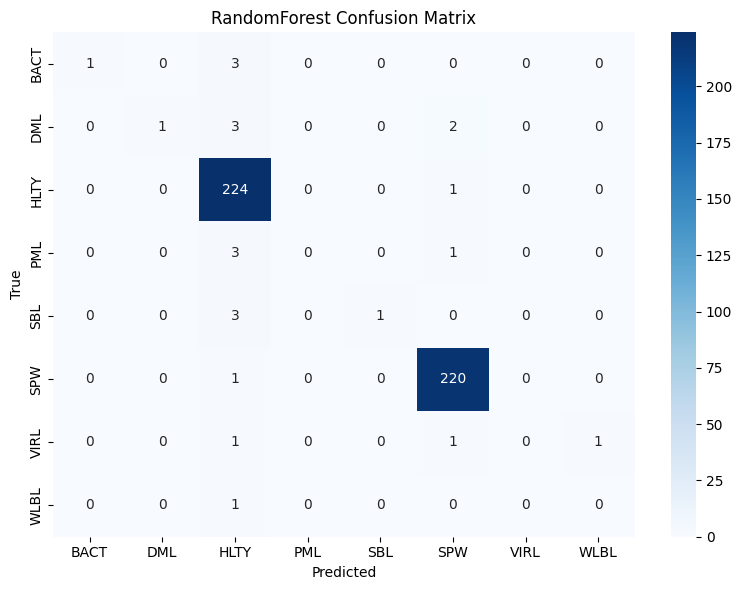

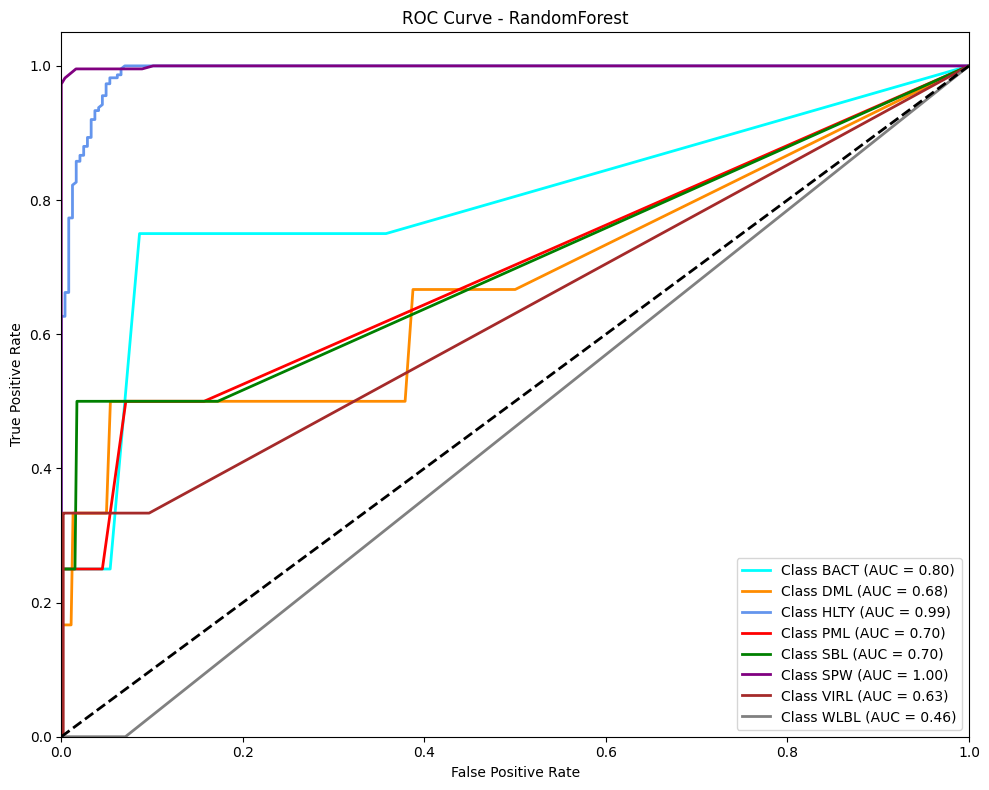

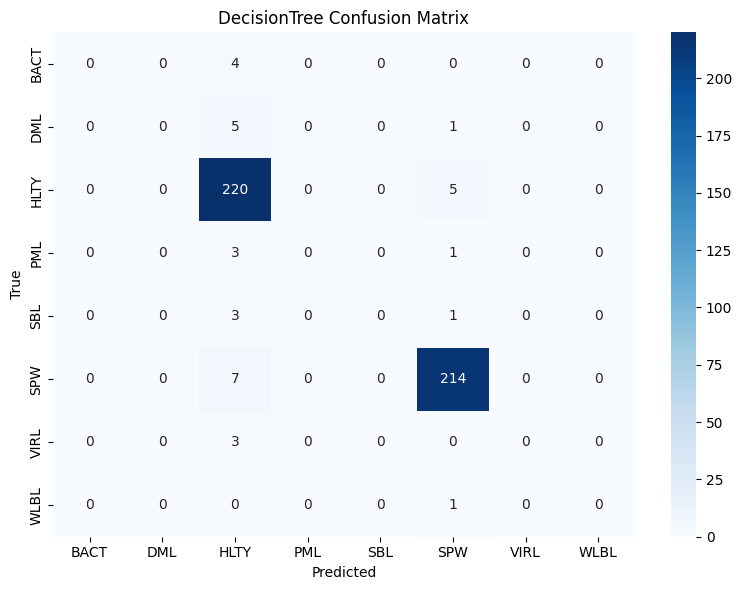

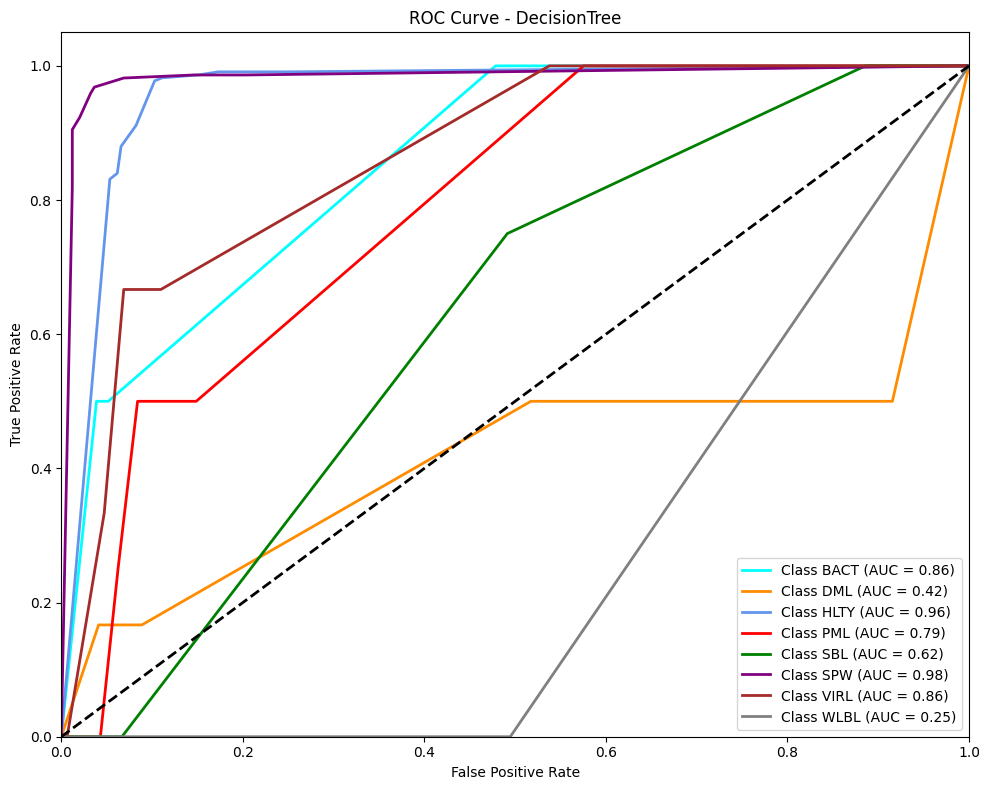

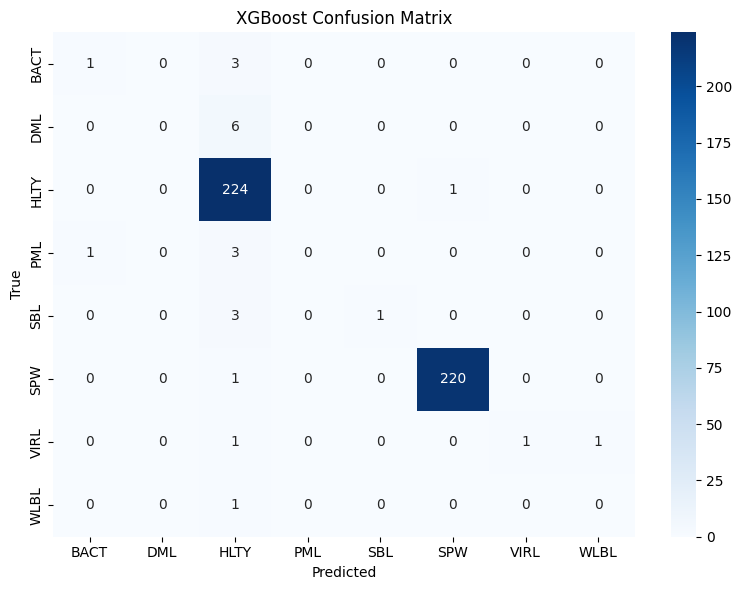

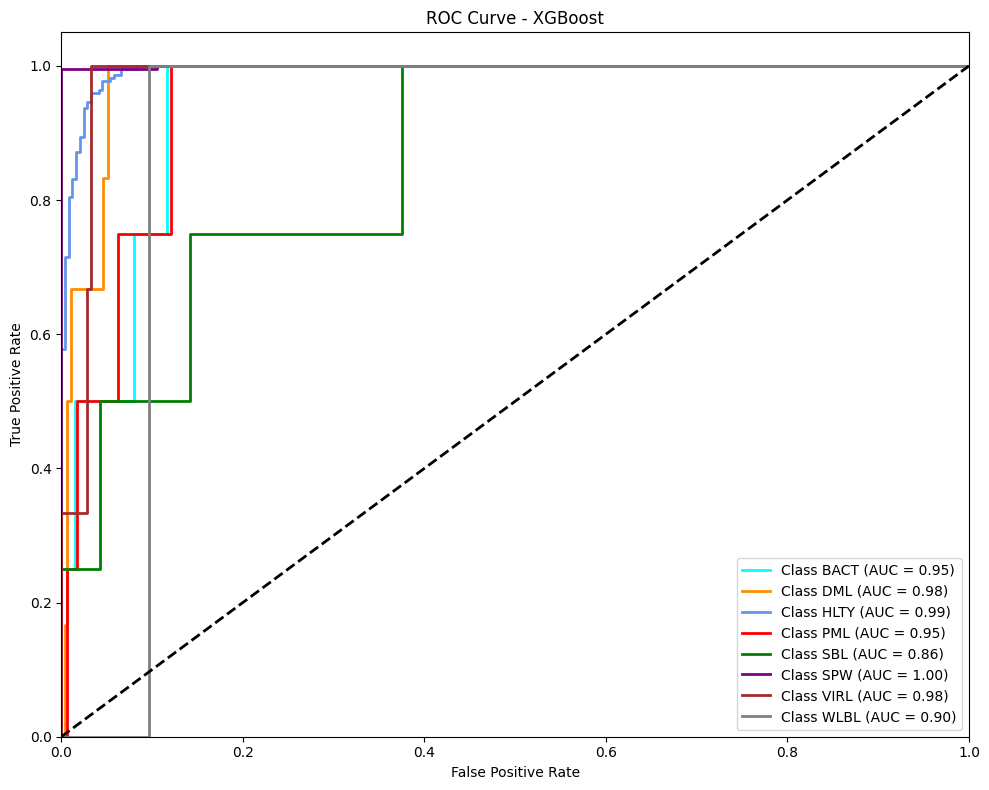

In [10]:
mlflow.set_experiment("Leaf_Classification_MultiClass- Classical ML Techniques")

""" Here we are setting up mlflow experimentations to keep track of various models and their metrics
"""


for model_name, (model, param_grid) in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"🔍 Training {model_name}...")

        grid = GridSearchCV(
            model, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
        )
        grid.fit(X_train_scaled, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_val_scaled)
        y_proba = best_model.predict_proba(X_val_scaled)

        # ------------------------
        # METRICS
        # ------------------------
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average="weighted")
        rec = recall_score(y_val, y_pred, average="weighted")
        f1 = f1_score(y_val, y_pred, average="weighted")

        # One-hot encode y for ROC-AUC
        classes = np.unique(y_encoded)
        y_bin = label_binarize(y_val, classes=classes)
        auc_score = roc_auc_score(y_bin, y_proba, average="weighted", multi_class="ovr")

        mlflow.log_params(grid.best_params_)
        mlflow.log_metrics(
            {
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1_score": f1,
                "roc_auc": auc_score,
            }
        )

        # ------------------------
        # CONFUSION MATRIX
        # ------------------------
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
        )
        plt.title(f"{model_name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        cm_path = f"{model_name}_confusion_matrix.png"
        plt.savefig(cm_path)
        mlflow.log_artifact(cm_path)

        # ------------------------
        # MULTI-CLASS ROC CURVE
        # ------------------------
        fpr, tpr, roc_auc = {}, {}, {}
        n_classes = len(classes)
        plt.figure(figsize=(10, 8))
        colors = cycle(
            [
                "aqua",
                "darkorange",
                "cornflowerblue",
                "red",
                "green",
                "purple",
                "brown",
                "gray",
            ]
        )

        for i, color in zip(range(n_classes), colors):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=2,
                label=f"Class {le.inverse_transform([i])[0]} (AUC = {roc_auc[i]:0.2f})",
            )

        plt.plot([0, 1], [0, 1], "k--", lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc="lower right")
        plt.tight_layout()
        roc_path = f"{model_name}_roc_curve.png"
        plt.savefig(roc_path)
        mlflow.log_artifact(roc_path)

        # ------------------------
        # LOG MODEL
        # ------------------------
        mlflow.sklearn.log_model(best_model, model_name + "_model")

        print(f"✅ {model_name} complete. Best Params: {grid.best_params_}")

In [11]:
best_estimators = {}  # Store for later voting

for model_name, (model, param_grid) in models.items():
    with mlflow.start_run(run_name=model_name):
        ...
        best_model = grid.best_estimator_

        # Save for voting later
        best_estimators[model_name] = best_model

In [12]:
model_metrics = {}

for model_name, model in best_estimators.items():
    y_pred = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_pred)
    model_metrics[model_name] = (acc, model)

# Sort models by accuracy (or f1/roc_auc etc.)
top_models = sorted(model_metrics.items(), key=lambda x: x[1][0], reverse=True)[:3]

# Extract the top 3 best models
voting_estimators = [(name, model) for name, (_, model) in top_models]

In [13]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=voting_estimators, voting="soft")
voting_clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred_voting = voting_clf.predict(X_val_scaled)
y_proba_voting = voting_clf.predict_proba(X_val_scaled)

from sklearn.metrics import classification_report, roc_auc_score

# ROC AUC
y_bin = label_binarize(y_val, classes=np.unique(y_val))
voting_auc = roc_auc_score(y_bin, y_proba_voting, multi_class="ovr", average="weighted")

print("Voting Classifier Report:")
print(classification_report(y_val, y_pred_voting))
print(f"Voting ROC AUC: {voting_auc:.4f}")

Voting Classifier Report:
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.00      0.00      0.00         6
           2       0.93      1.00      0.96       225
           3       0.00      0.00      0.00         4
           4       1.00      0.25      0.40         4
           5       1.00      1.00      1.00       221
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         1

    accuracy                           0.96       468
   macro avg       0.55      0.35      0.40       468
weighted avg       0.93      0.96      0.94       468

Voting ROC AUC: 0.9938


In [14]:
with mlflow.start_run(run_name="VotingClassifier"):
    acc = accuracy_score(y_val, y_pred_voting)
    f1 = f1_score(y_val, y_pred_voting, average="weighted")
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", voting_auc)

    mlflow.sklearn.log_model(voting_clf, "voting_classifier_model")

2025/07/23 02:46:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 02:46:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
